## Тестовое задание для стажировки в ABBYY по напрвлению NLP. 
### Выполнил Евгений Лагутин.
------------------

Датасет - характеристики красных вин и выставленные им оценки качества. Задача - по характеристике вина во|сстановить его качество. 

Далее:
* Первичный анализ данных
* постановка задачи
* Выбор метрики качества
* Сравнение моделей
* Fine-tuning лучшей модели
* Построение ансамбля

In [312]:
# import necessary libraries
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion

import xgboost
from xgboost import XGBClassifier

plt.style.use('ggplot')
sns.set()

%matplotlib inline

In [299]:
# load the dataset
df = pd.read_csv("./winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [300]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df.quality, test_size=0.33, random_state=42)

# farther, we will only look at the training data to avoid bias from the test data
df_train = X_train.copy()
df_train['quality'] = y_train
df_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000
mean,8.303455,0.532465,0.269337,2.546919,0.087727,15.912232,46.763305,0.996779,3.314538,0.658814,10.415219,5.621849
std,1.707197,0.177055,0.195814,1.407782,0.047312,10.287787,32.994509,0.001843,0.154349,0.173023,1.063407,0.804107
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000,3.000000
25%,7.100000,0.400000,0.090000,1.900000,0.071000,7.000000,22.000000,0.995695,3.220000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.080000,14.000000,38.000000,0.996800,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.090000,21.000000,63.000000,0.997830,3.400000,0.730000,11.000000,6.000000
max,15.900000,1.330000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [301]:
# unique values of quality 
sorted(df_train['quality'].unique())

[3, 4, 5, 6, 7, 8]

No Nans

Признаки могут быть отнормированы, т.к. их значения в разных единицах измерения, а у нас нет предположения о том, как они должны соотноситься.

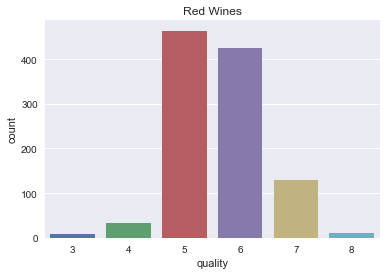

In [302]:
# distribution of quality value in the traning dataset
x = sns.countplot(data=df_train, x="quality")
plt.title("Red Wines")
plt.show()

Для классификации такое распределение - очень неравномерное. 

Хорошим решением было бы слияние некоторых классов в один, но постановка задачи этого не предполагает.

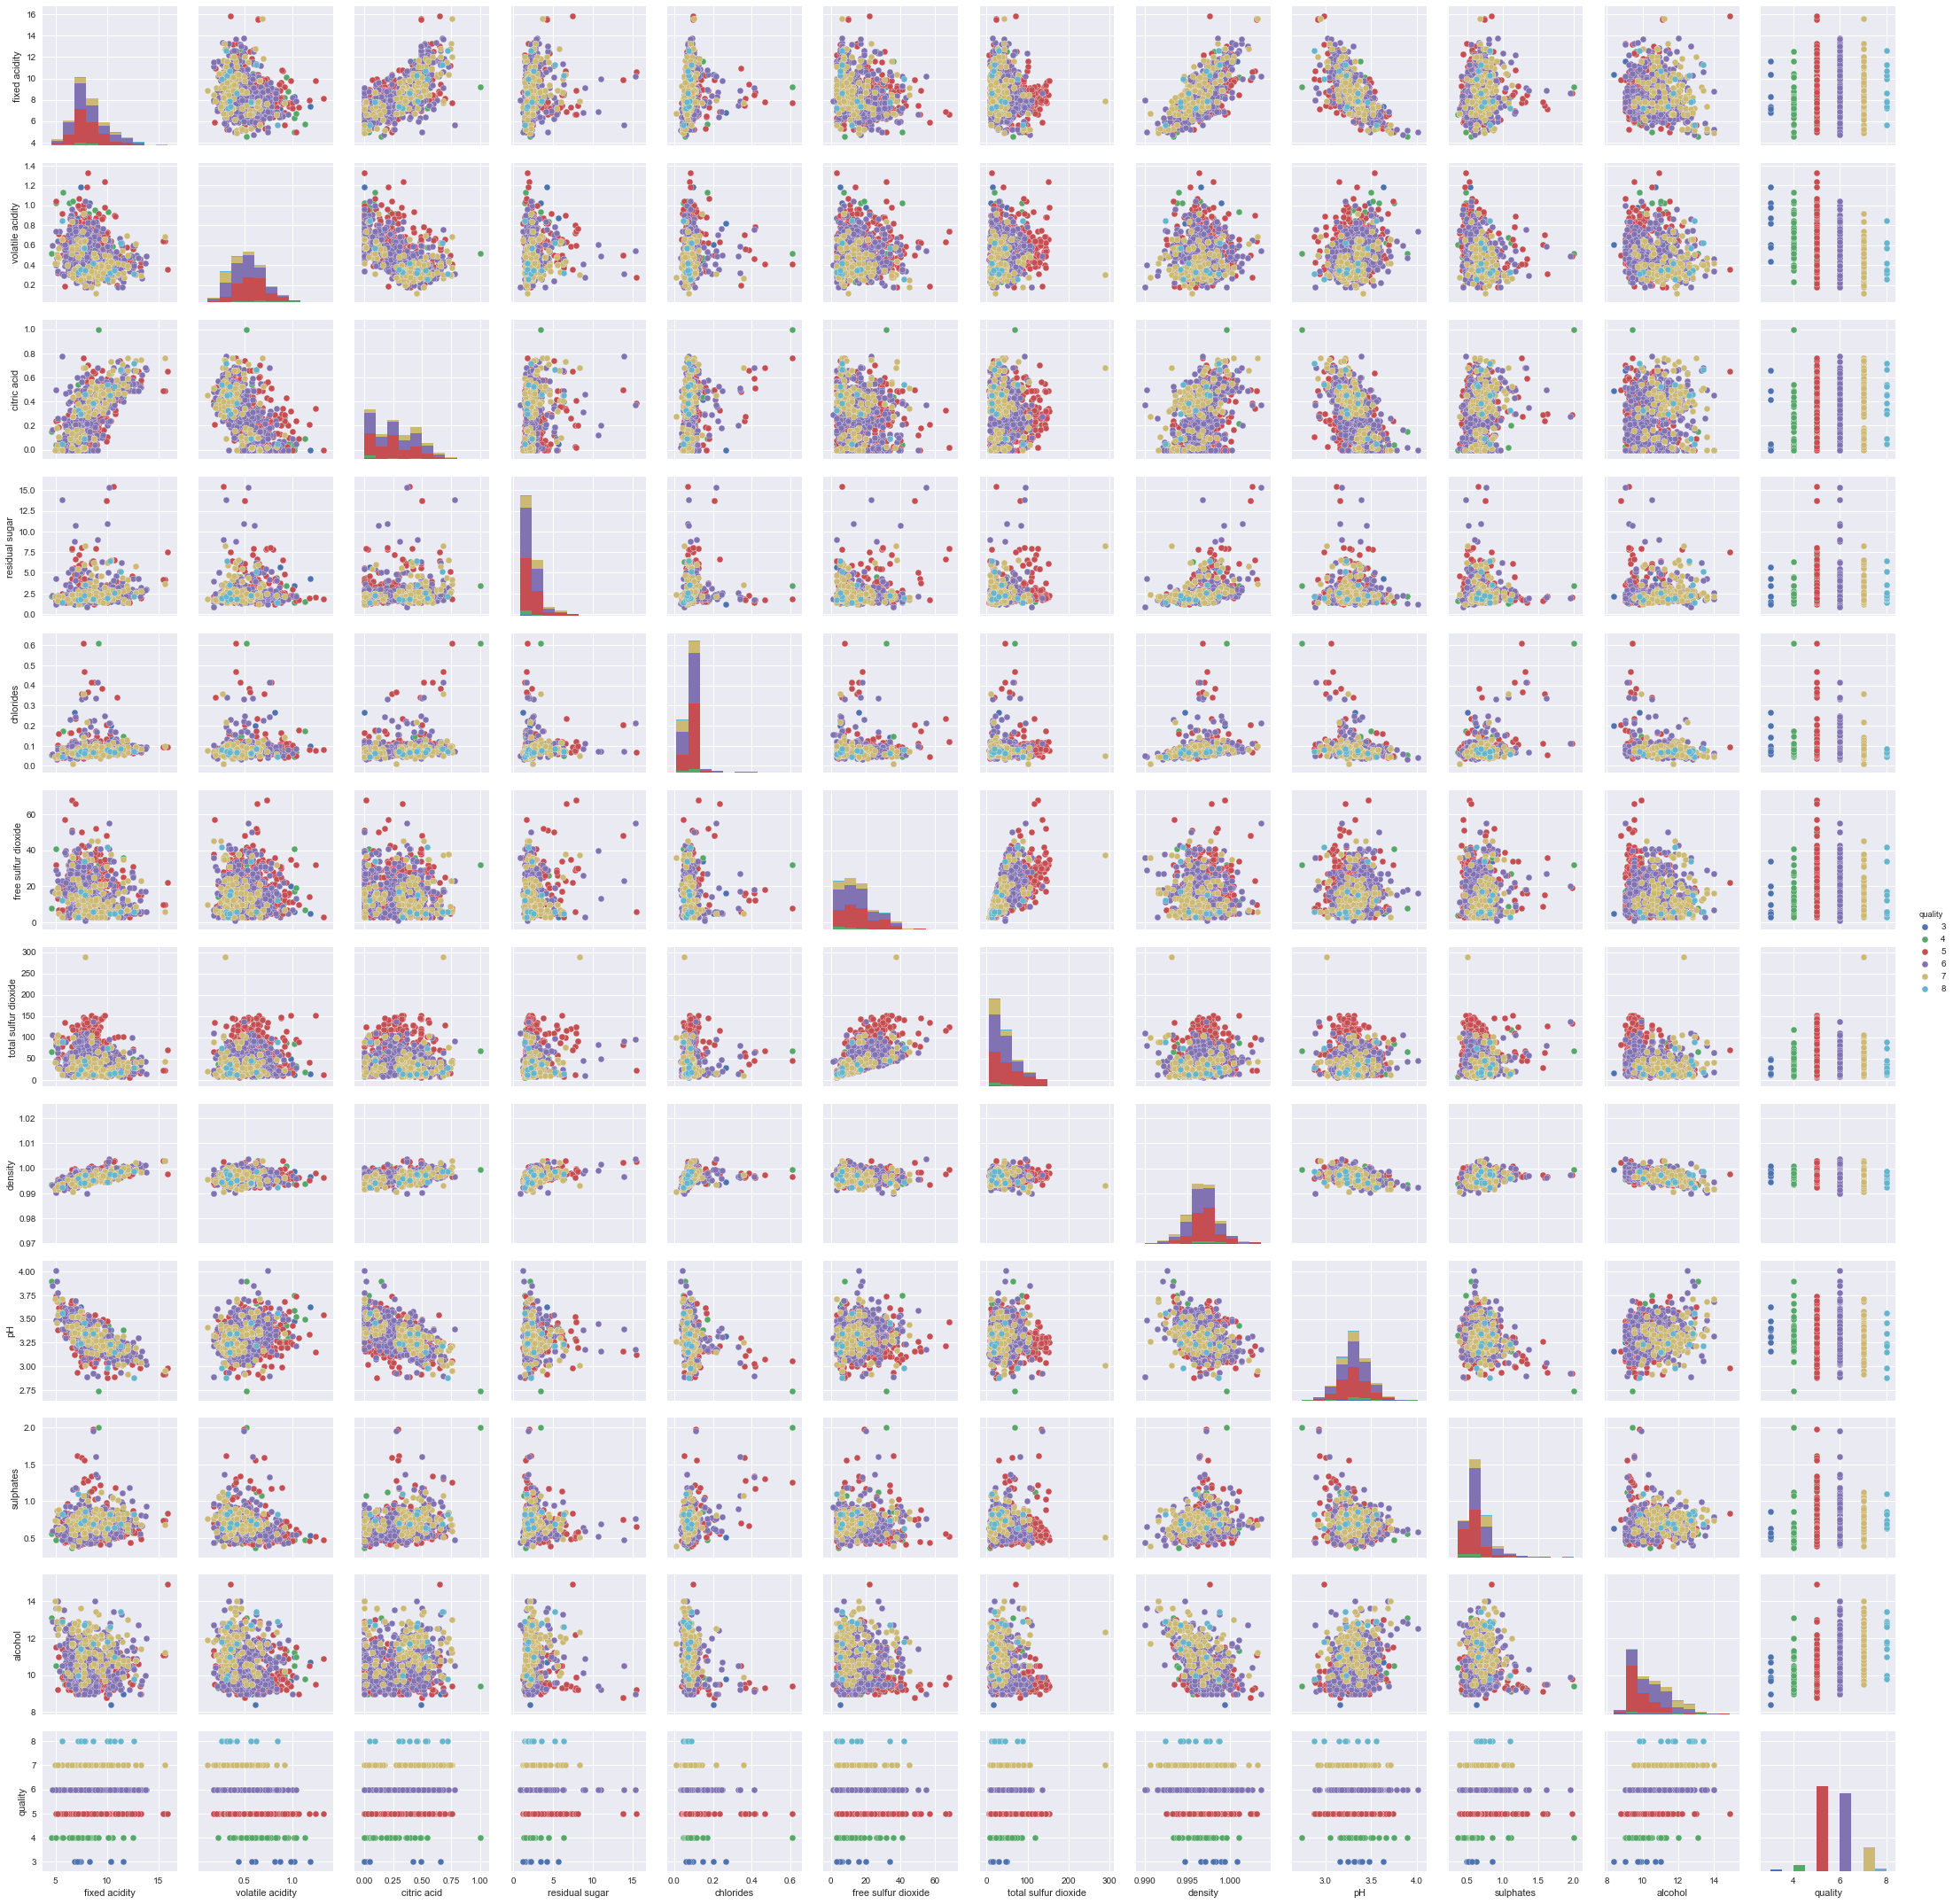

In [845]:
# features' distributions and correlations
sns.pairplot(df_train, hue='quality')

К сожалению, из этого графика нельзя сделать никаких предположений о зависимостях в данных. Видно, что вина с оценками 5 и 6 выделяются, остальные же разделить достаточно сложно.

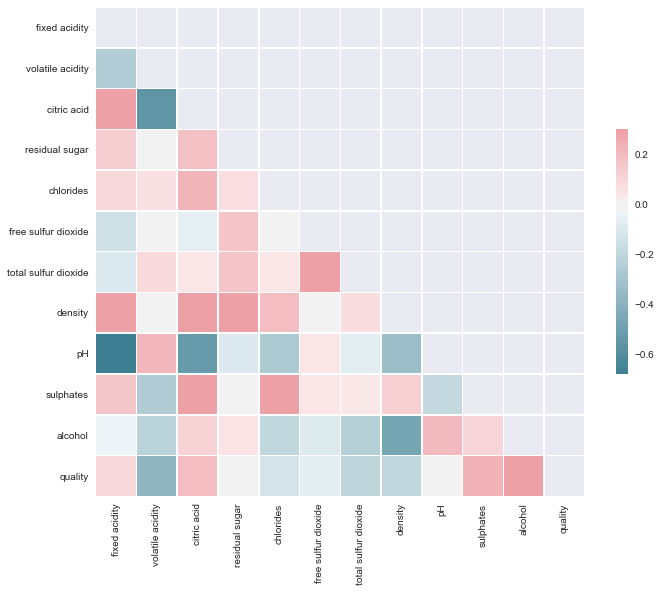

In [198]:
from string import ascii_letters

# Compute the correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

По корреляционной матрице можно сказать, что признаки не сильно скоррелированы между собой и слабо коррелируют с целевым признаком.

Посмотрим более внимательно на некоторые признаки.

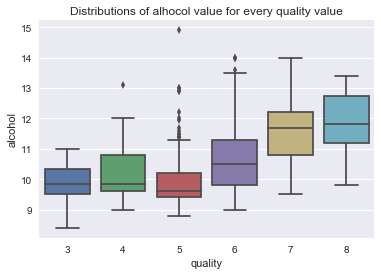

In [200]:
sns.boxplot('quality', 'alcohol', data = df_train)
plt.title("Distributions of alhocol value for every quality value")
plt.show()

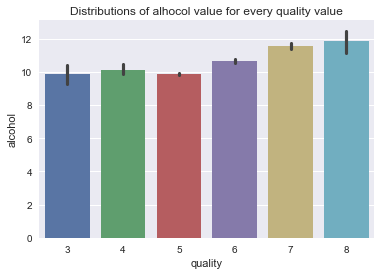

In [201]:
plt.title("Distributions of alhocol value for every quality value")
sns.barplot(data=df_train, x="quality", y="alcohol")
plt.show()

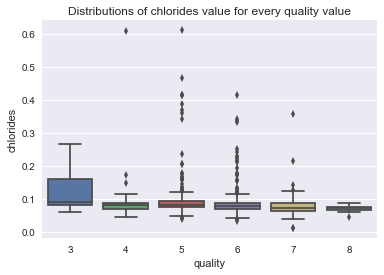

In [203]:
plt.title("Distributions of chlorides value for every quality value")
sns.boxplot('quality', 'chlorides', data = df_train)
plt.show()

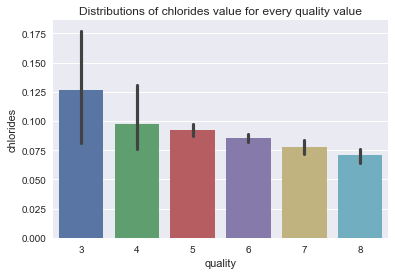

In [204]:
plt.title("Distributions of chlorides value for every quality value")
sns.barplot(data=df_train, x="quality", y="chlorides")
plt.show()

Явных линейных зависимостей не наблюдается, вероятно, нелинейные модели дадут лучший результат в этой задаче.

---------------------------------
## Выбор модели
На задачу можно посмотреть с двух сторон: как на задачу регрессии и классификации. Я выбираю путь классификации, потому что мне кажется, что выбор из пяти возможных значений, которые принимает целевая метка, осуществляется человеком по принципу классификации, хотя это всего лишь моё предположение.

**Модели классификации:**

* Logistic Regression (linear_model.SGDClassifier with loss='log') (+ Principal Component Analysis) 
* Support Vector Machine classifier (linear_model.SGDClassifier with loss='hinge') (+ Principal Component Analysis) 
* Random Forest classifier
* K Nearest Neighbours
* XGBClassifier
* Ensemble of all
* Fully-connected nn with softmax

    **Метрика качества:** 
    
    Выбор метрики качества классификации зависит от задачи. 
    
    Так как в условии не предложено метрики, я выберу её сам.
    
    Из распределения данных видно, что очень просто угадать качество вина, потому что в большинстве случаев выставляется оценка 5 или 6. Поэтому мы попытаемся построить модель, которая бы хорошо угадывала все классы, а не только 5, 6, 7, как будет происходить с деревянными моделями в случае выбора взвешенной метрики. Иными словами, если вино лучше или хуже среднего, мы бы хотели это выявить, несмотря на то, что это произойдёт с малой вероятностью. 
    
    Итого, выберем метрику многоклассовой классификации F1-macro - невзвешенную F1 метрику.

In [491]:
# common cross-validation split

cv = StratifiedKFold(n_splits=3, shuffle=True)

In [156]:
# function to plot confusion matrix (useful for multilayer classification)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

## Классификация

In [234]:
# dicts of models and test predictions of every model
predictions = {}
models = {}

---------------------------------
### PCA + Linear Regression with poly features

In [313]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('pca', PCA()),
    ('clf', SGDClassifier(loss='log', n_jobs=-1, early_stopping=True))
])

param_grid = [
    {
        'clf__alpha': np.logspace(-5, 0, 6),
        'clf__max_iter': [500, 1000],
        'pca__n_components' : [len(X_train.columns), 8],
        'clf__penalty' : ['elasticnet', 'l2'],
        'poly__degree' : [2, 3]
    },
    {
        'pca' : [None],
        'clf__alpha': np.logspace(-5, 0, 6),
        'clf__max_iter': [500, 1000],
        'clf__penalty' : ['elasticnet', 'l2'],
        'poly__degree' : [2, 3]
    },
    {
        'pca' : [None],
        'clf__alpha': np.logspace(-5, 0, 6),
        'clf__max_iter': [500, 1000],
        'clf__penalty' : ['elasticnet', 'l2'],
        'poly' : [None]
    },
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2, scoring='f1_macro')
grid.fit(X_train, y_train)

predicted = grid.predict(X_test)
predictions['lrc'] = predicted
models['lrc'] = grid

print('F1 macro score:\t{}'.format(f1_score(y_test, predicted, average='macro')))

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed: 16.0min finished


F1 macro score:	0.3593794554553078


In [314]:
grid.best_params_

{'clf__alpha': 0.001,
 'clf__max_iter': 500,
 'clf__penalty': 'l2',
 'pca': None,
 'poly__degree': 3}

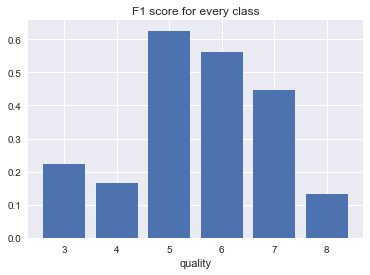

In [315]:
plt.bar([3,4,5,6,7,8], height=f1_score(y_test, predictions['lrc'], average=None))
plt.title('F1 score for every class')
plt.xlabel('quality')
plt.show()

Normalized confusion matrix


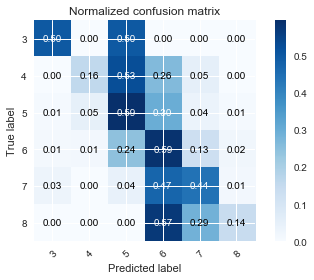

In [316]:
plot_confusion_matrix(y_test, predictions['lrc'], classes=[3,4,5,6,7,8], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

---------------------------
### Random Forest with poly features

In [317]:
pipe = Pipeline([
#    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('clf', RandomForestClassifier(n_jobs=-1, bootstrap=True, oob_score=True))
])

param_grid = [
    {
        'clf__max_depth': [2, 4, 6, 10],
        'clf__n_estimators' : [100, 400],
        'poly__degree' : [2, 3],
        'clf__class_weight' : [None, 'balanced', 'balanced_subsample']
    },
    {
        'poly' : [None],
        'clf__max_depth': [2, 4, 6, 10],
        'clf__n_estimators' : [100, 400],
        'clf__class_weight' : [None, 'balanced', 'balanced_subsample']
    },
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2, scoring='f1_macro')
grid.fit(X_train, y_train)

predicted = grid.predict(X_test)
predictions['rfc'] = predicted
models['rfc'] = grid

print('Score:\t{}'.format(f1_score(y_test, predicted, average='macro')))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  2.0min finished


Score:	0.34932607529330784


In [318]:
grid.best_params_

{'clf__class_weight': 'balanced',
 'clf__max_depth': 10,
 'clf__n_estimators': 100,
 'poly': None}

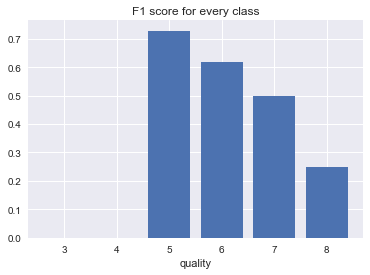

In [319]:
plt.bar([3,4,5,6,7,8], height=f1_score(y_test, predictions['rfc'], average=None))
plt.title('F1 score for every class')
plt.xlabel('quality')
plt.show()

In [320]:
# a look at feature importance

max(grid.best_estimator_.named_steps['clf'].feature_importances_)

0.14890055254081827

Normalized confusion matrix


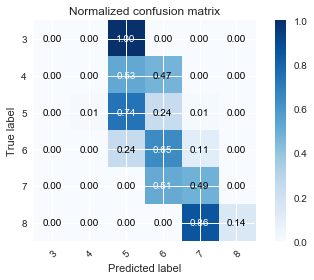

In [321]:
plot_confusion_matrix(y_test, predictions['rfc'], classes=[3,4,5,6,7,8], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

---------------------------------
### PCA + SVC

Попробуем применить метод, SVM. Из pairplot видно, что классы разделяются плохо, поэтому ожидать очень хороших результатов от SVM не стоит.

In [322]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('pca', PCA()),
    ('clf', SGDClassifier(loss='hinge', early_stopping=True, n_jobs=-1))
])

param_grid = [
    {
        'clf__alpha': np.logspace(-5, 0, 6),
        'clf__max_iter': [500, 1000],
        'pca__n_components' : [len(X_train.columns), 8],
#        'clf__penalty' : ['elasticnet', 'l2'],
        'poly__degree' : [2, 3]
    },
    {
        'pca' : [None],
        'clf__alpha': np.logspace(-5, 0, 6),
        'clf__max_iter': [500, 1000],
#        'clf__penalty' : ['elasticnet', 'l2'],
        'poly__degree' : [2, 3]
    },
    {
        'pca' : [None],
        'clf__alpha': np.logspace(-5, 0, 6),
        'clf__max_iter': [500, 1000],
#        'clf__penalty' : ['elasticnet ', 'l2'],
        'poly' : [None]
    },
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2, scoring='f1_macro')
grid.fit(X_train, y_train)

predicted = grid.predict(X_test)
predictions['svc'] = predicted
models['svc'] = grid

print('Score:\t{}'.format(f1_score(y_test, predicted, average='macro')))

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:  6.1min finished


Score:	0.37596110046461956


In [323]:
grid.best_params_

{'clf__alpha': 0.01, 'clf__max_iter': 1000, 'pca': None, 'poly__degree': 3}

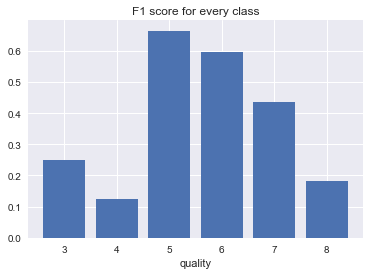

In [324]:
plt.bar([3,4,5,6,7,8], height=f1_score(y_test, predictions['svc'], average=None))
plt.title('F1 score for every class')
plt.xlabel('quality')
plt.show()

Normalized confusion matrix


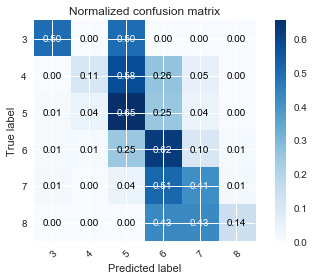

In [325]:
plot_confusion_matrix(y_test, predictions['svc'], classes=[3,4,5,6,7,8], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

------------------------
### XGBClassifier

In [505]:
pipe = Pipeline([
#    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('clf', XGBClassifier(n_jobs=-1))
])


param_grid = {
              'clf__learning_rate': [0.01], #so called `eta` value
              'clf__max_depth': [4, 6, 10],
#              'min_child_weight': [11],
#              'silent': [1],
              'clf__subsample': [0.8],
              'clf__colsample_bytree': [0.7],
              'clf__n_estimators': [100, 400],
              'clf__seed': [42],
              'poly' : [PolynomialFeatures(2), PolynomialFeatures(3), None]
             }

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2, scoring='f1_macro')
grid.fit(X_train, y_train)   

predicted = grid.predict(X_test)
predictions['xgb'] = predicted
models['xgb'] = grid

print('Score:\t{}'.format(f1_score(y_test, predicted, average='macro')))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  9.4min finished


Score:	0.4320369210571831


In [506]:
grid.best_params_

{'clf__colsample_bytree': 0.7,
 'clf__learning_rate': 0.01,
 'clf__max_depth': 6,
 'clf__n_estimators': 400,
 'clf__seed': 42,
 'clf__subsample': 0.8,
 'poly': PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)}

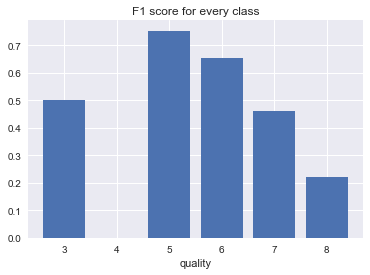

In [507]:
plt.bar([3,4,5,6,7,8], height=f1_score(y_test, predictions['xgb'], average=None))
plt.title('F1 score for every class')
plt.xlabel('quality')
plt.show()

In [508]:
max(grid.best_estimator_.named_steps['clf'].feature_importances_)

0.016272541

Normalized confusion matrix


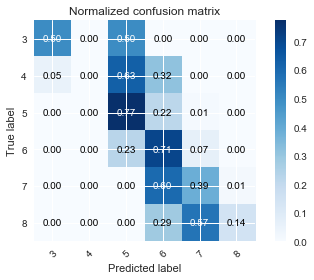

In [509]:
plot_confusion_matrix(y_test, predictions['xgb'], classes=[3,4,5,6,7,8], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

-------
### K Nearest Neighbors

In [331]:
from sklearn.neighbors import KNeighborsClassifier

In [332]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', KNeighborsClassifier(n_jobs=-1))
])


param_grid = [{
              'clf__n_neighbors' : [1, 3, 5, 7, 10],
              'clf__metric' : ['manhattan', 'euclidean', 'minkowski'],
              'clf__weights' : ['distance', 'uniform'],
              'clf__algorithm' : ['auto', 'ball_tree']
             }, 
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2, scoring='f1_macro')
grid.fit(X_train, y_train)

predicted = grid.predict(X_test)
predictions['knn'] = predicted
models['knn'] = grid

print('Score:\t{}'.format(f1_score(y_test, predicted, average='macro')))

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.5s


Score:	0.36260332105901466


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.1s finished


In [520]:
grid.best_params_

{'clf__algorithm': 'auto',
 'clf__metric': 'manhattan',
 'clf__n_neighbors': 1,
 'clf__weights': 'distance'}

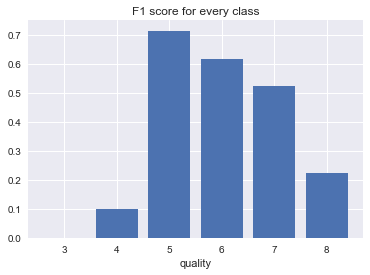

In [334]:
plt.bar([3,4,5,6,7,8], height=f1_score(y_test, predictions['knn'], average=None))
plt.title('F1 score for every class')
plt.xlabel('quality')
plt.show()

Normalized confusion matrix


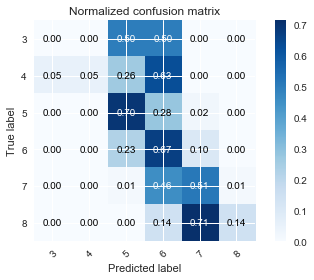

In [335]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predictions['knn'], classes=[3,4,5,6,7,8], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Из приведённых оценок качества моделей и confusion матриц видно, что, хотя некоторые модели работают явно лучше и их стоит пподогнать лучше (я, конечно, имею в виду xgboost), модели ошибаются неодинако, из чего можно сделать вывод, что ансамбль моделей мог бы улучшить качество работы на отдельных классах.

-------------------------------
## Evaluating models

In [512]:
train_scores = {}
test_scores = {}
train_preds = {}
for model in models:
    exe_model = models[model].best_estimator_
    train_preds[model] = exe_model.predict(X_train)
    train_scores[model] = np.mean(cross_val_score(exe_model, X_train, y_train, cv=3, scoring='f1_macro'))
    test_scores[model] = f1_score(y_test, predictions[model], average='macro')

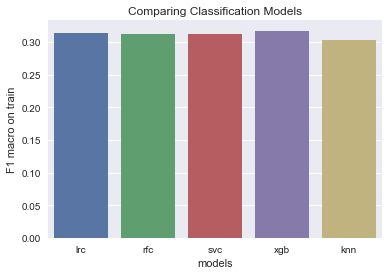

In [513]:
pred_df = pd.DataFrame(predictions)
sns.barplot(x=list(train_scores.keys()), y=list(train_scores.values()))
plt.ylabel('F1 macro on train')
plt.xlabel('models')
plt.title('Comparing Classification Models')
plt.show()

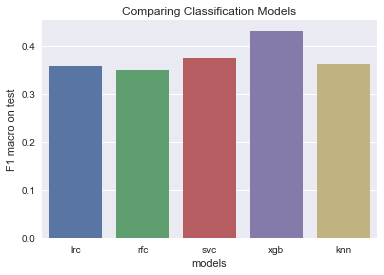

In [514]:
pred_df = pd.DataFrame(predictions)
sns.barplot(x=list(test_scores.keys()), y=list(test_scores.values()))
plt.ylabel('F1 macro on test')
plt.xlabel('models')
plt.title('Comparing Classification Models')
plt.show()

---------
## Ensemble

Построим ансамбль на предыдущих моделях, а именно построим новую модель, для которой признаками будут предсказания классификаторов выше. 

После нескольких попыток, было решено взять в качестве классификатора KNeighborsClassifier

In [515]:
test_pred_df = pred_df.copy()
train_pred_df = pd.DataFrame(train_preds)
train_pred_df.head()

pipe = Pipeline([
#    ('scale', StandardScaler()),
    ('clf', KNeighborsClassifier(n_jobs=-1))
])


param_grid = [{
              'clf__n_neighbors' : [1, 3, 5, 7, 10],
              'clf__metric' : ['manhattan', 'euclidean', 'minkowski'],
              'clf__weights' : ['distance', 'uniform'],
              'clf__algorithm' : ['auto', 'ball_tree']
             }, 
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=4, n_jobs=-1, verbose=2, scoring='f1_macro')
grid.fit(train_pred_df, y_train)

predicted = grid.predict(test_pred_df)


print('Score:\t{}'.format(f1_score(y_test, predicted, average='macro')))

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s


Score:	0.4773911769069928


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   15.5s finished


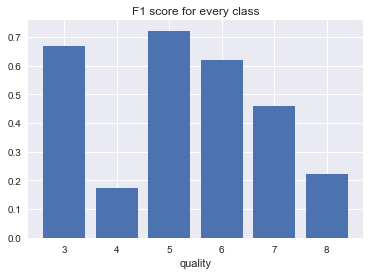

In [516]:
plt.bar([3,4,5,6,7,8], height=f1_score(y_test, predicted, average=None))
plt.title('F1 score for every class')
plt.xlabel('quality')
plt.show()

Normalized confusion matrix


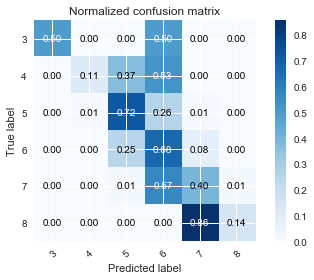

In [517]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predicted, classes=[3,4,5,6,7,8], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [518]:
exe_model = grid.best_estimator_
train_preds['ensemble'] = exe_model.predict(train_pred_df)
train_scores['ensemble'] = np.mean(cross_val_score(exe_model, train_pred_df, y_train, cv=3, scoring='f1_macro'))
test_scores['ensemble'] = f1_score(y_test, predicted, average='macro')

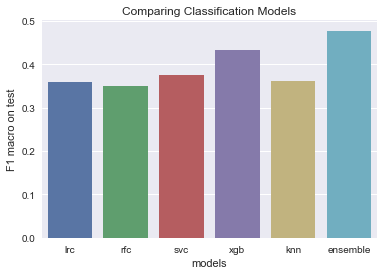

In [519]:
pred_df = pd.DataFrame(predictions)
sns.barplot(x=list(test_scores.keys()), y=list(test_scores.values()))
plt.ylabel('F1 macro on test')
plt.xlabel('models')
plt.title('Comparing Classification Models')
plt.show()

# Подведение итогов

Итак, ансамбль на базовых моделях классификации даёт вполне удовлетворительный результат.

-----
## P.S. Fully-connected nn

Ради интереса попробуем применить простенькую полносвязную нейросетку. Заранее больших надежд при таком мальком количестве данных нет, поэтому делается это для примера.

In [829]:
import torch
from torch import nn
from torch.autograd import Variable 

device = torch.device('cpu')

In [830]:
train_data = torch.FloatTensor(np.array(X_train))
train_labels = torch.tensor(np.array(y_train - 3))

In [839]:
input_size = X_train.shape[1]
output_size = len(y_train.unique())

n_epochs = 1000
batch_size = 64
batch_per_ep = X_train.shape[0] // batch_size
print_every = 100

In [840]:
model = nn.Sequential(
          nn.Linear(input_size, 64),
          nn.ReLU(),
          nn.Linear(64, output_size),
          nn.ReLU(),
          nn.LogSoftmax(dim=-1)
        ).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0., weight_decay=0.02)

In [841]:
model.train()
total_loss = 0
for ep in range(n_epochs):
    for i in range(batch_per_ep):
        inputs = train_data[i*batch_size : (i+1)*batch_size % train_data.size(0)]
        labels = train_labels[i*batch_size : (i+1)*batch_size % train_data.size(0)]
        inputs, labels = Variable(inputs).to(device),  Variable(labels).to(device)
        
        outputs = model(inputs)
        #print(outputs.size(), labels.size())
        loss = loss_function(outputs, labels)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if ((1 + ep) % print_every == 0):
        print("Epoch : {}, Loss : {}".format(ep, total_loss / batch_per_ep))
    total_loss = 0

Epoch : 99, Loss : 1.1395409256219864
Epoch : 199, Loss : 1.1197026260197163
Epoch : 299, Loss : 1.105973720550537
Epoch : 399, Loss : 1.0948031917214394
Epoch : 499, Loss : 1.0851620584726334
Epoch : 599, Loss : 1.076520811766386
Epoch : 699, Loss : 1.0686391294002533
Epoch : 799, Loss : 1.0614365190267563
Epoch : 899, Loss : 1.0548229403793812
Epoch : 999, Loss : 1.0487543977797031


In [842]:
model.eval()
preds = torch.argmax(model(train_data), 1) + 3
print("Training score : {}".format(f1_score(y_train, np.array(preds), average='macro')))

Training score : 0.2016151910015199


In [843]:
model.eval()
test_data = torch.FloatTensor(np.array(X_test))
preds = torch.argmax(model(test_data), 1) + 3
print("Testing score : {}".format(f1_score(y_test, np.array(preds), average='macro')))

Testing score : 0.1845913804118139


Как видно, результат удручающий.